# Unsupervised Learning

"*Let the data set speak for itself*"
Jake VanderPlas

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

In [32]:
# Calculate fingerprints or descriptors
def calc_mol_props(m, fp=True):
    if fp:
        return list(AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=2048).ToBitString())
    else: 
        dts = [Descriptors.TPSA(m), round(Descriptors.MolLogP(m), 2), round(Descriptors.MolWt(m), 2),
        Descriptors.NumAromaticRings(m), Descriptors.NumHAcceptors(m), Descriptors.NumHDonors(m)]
        return dts

In [33]:
# upload chemical data
df = pd.read_csv('cyp3a4-clean.smi', sep='\t')
mols = [Chem.MolFromSmiles(s) for s in df.smiles.tolist()]

# generate fingerprints of the compounds
%time fps = np.array([calc_mol_props(m) for m in mols])
fps = pd.DataFrame(data=fps)

# generate descriptors of the compounds
%time dts = np.array([calc_mol_props(m, fp=False) for m in mols])
dts = pd.DataFrame(data=dts, columns=['TPSA', 'LogP', 'MW', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors'])

CPU times: user 1.99 s, sys: 49 ms, total: 2.04 s
Wall time: 2.04 s
CPU times: user 2.61 s, sys: 76.7 ms, total: 2.69 s
Wall time: 2.69 s


In [34]:
scaler = StandardScaler()
scaler.fit(dts) 
dts_scaled = scaler.transform(dts)

<h2>Dimensionality Reduction</h2>

<hr>

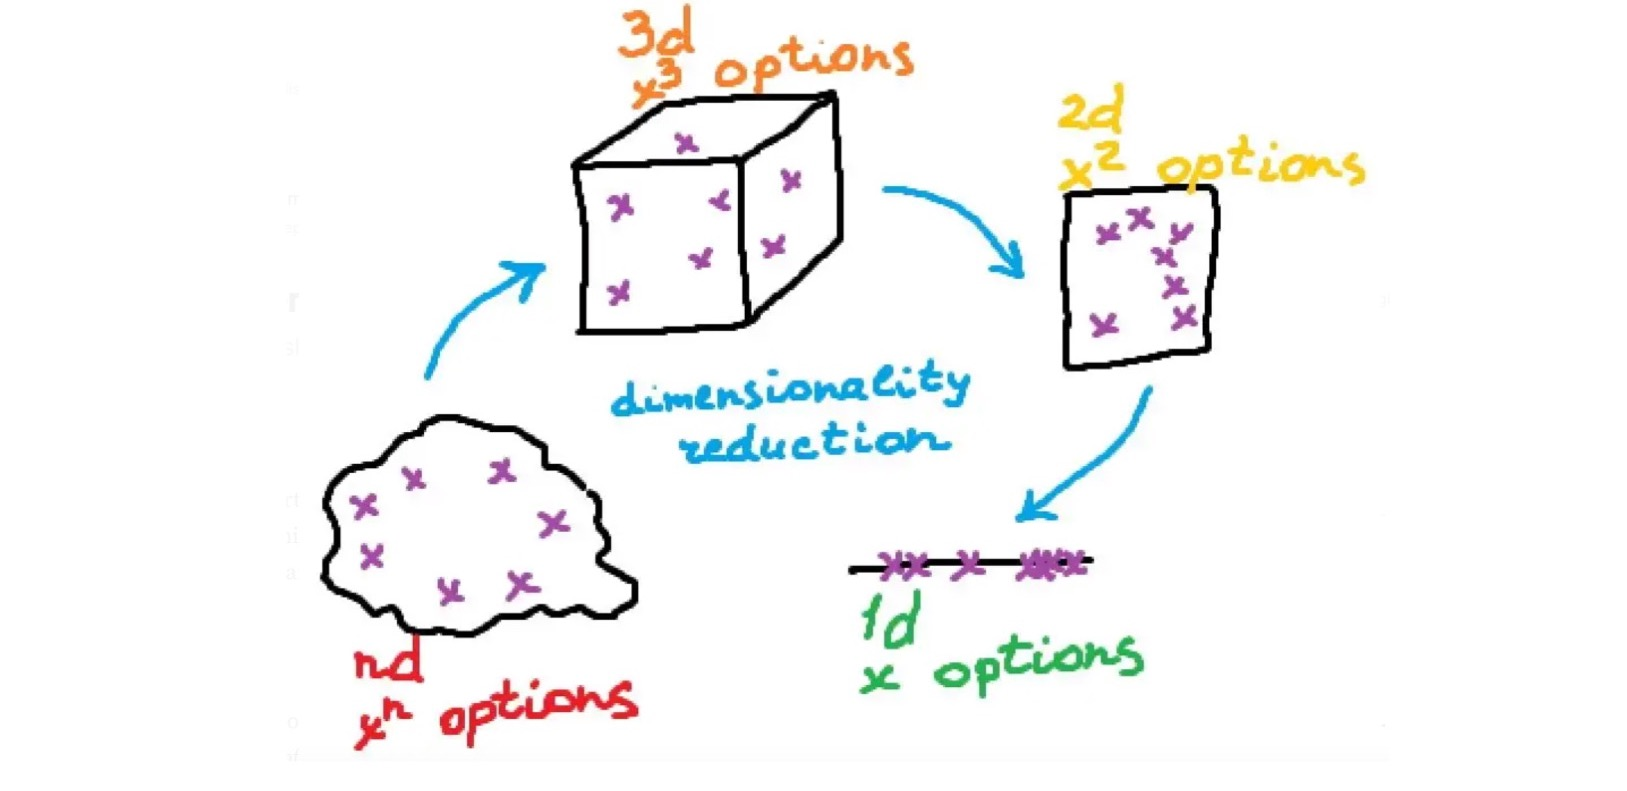

<h3>Principal component analysis (PCA)</h3>

In [35]:
pca = PCA(n_components=2)
%time crds_pca = pca.fit_transform(fps)

CPU times: user 1.3 s, sys: 374 ms, total: 1.67 s
Wall time: 804 ms


In [36]:
#PCA as a dimensionality reduction method
print("original shape:   ", fps.shape)
print("transformed shape:", crds_pca.shape)

original shape:    (4653, 2048)
transformed shape: (4653, 2)


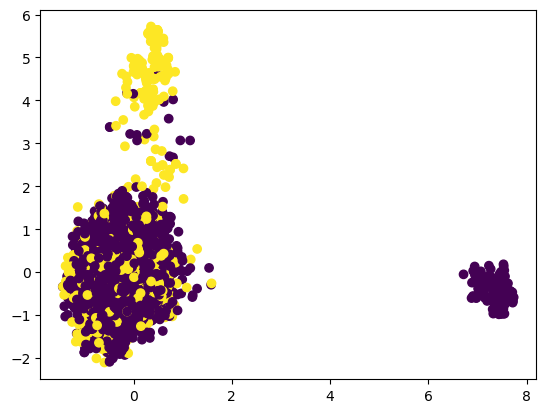

In [37]:
# PCA for 2D visualization
plt.scatter(crds_pca[:, 0], crds_pca[:, 1], c=df.status.tolist())
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


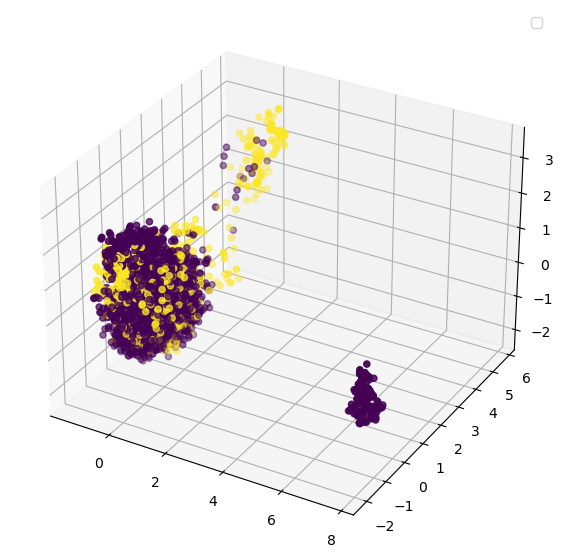

In [8]:
# 3D plot
pca = PCA(n_components=3)
pca.fit(fps) 
fps_pca_3d = pca.transform(fps)

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(fps_pca_3d[:, 0], fps_pca_3d[:, 1], fps_pca_3d[:, 2], c=df.status.tolist())

ax.legend()
plt.show()

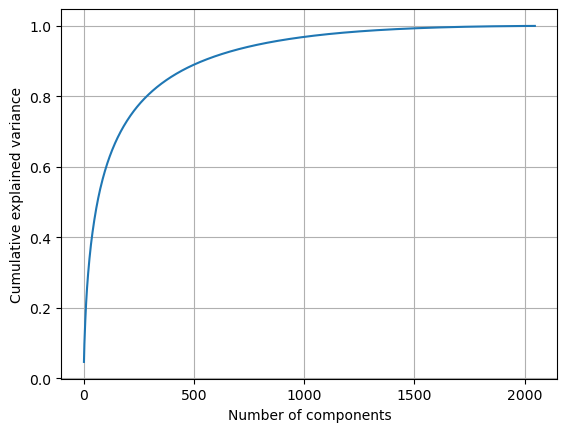

In [9]:
# explained variance ratio
pca = PCA().fit(fps)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.show()

<h3>t-SNE - t-distributed stochastic neighbor embedding</h3>

is a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two or three-dimensional map

/Users/meddwl/miniconda3/envs/rd22/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/meddwl/miniconda3/envs/rd22/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


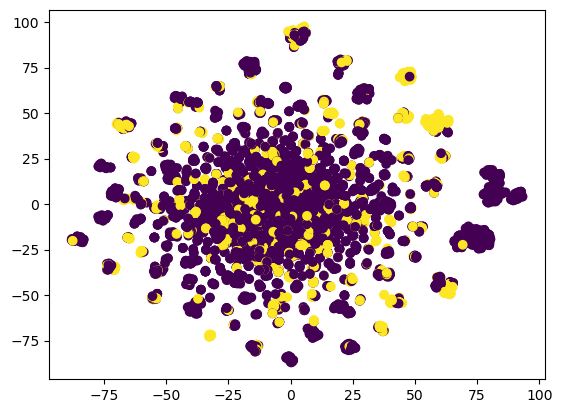

In [10]:
tsne = TSNE(n_components=2)
crds_tsne = tsne.fit_transform(fps)
plt.scatter(crds_tsne[:, 0], crds_tsne[:, 1], c=df.status.tolist())
plt.show()

/Users/meddwl/miniconda3/envs/rd22/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/meddwl/miniconda3/envs/rd22/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


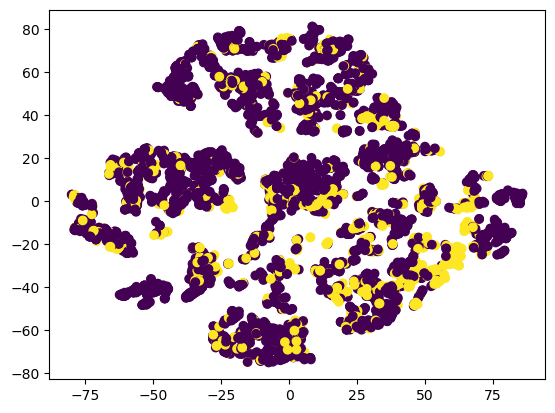

In [11]:
tsne = TSNE(n_components=2)
crds_tsne = tsne.fit_transform(dts_scaled)
plt.scatter(crds_tsne[:, 0], crds_tsne[:, 1], c=df.status.tolist())
plt.show()

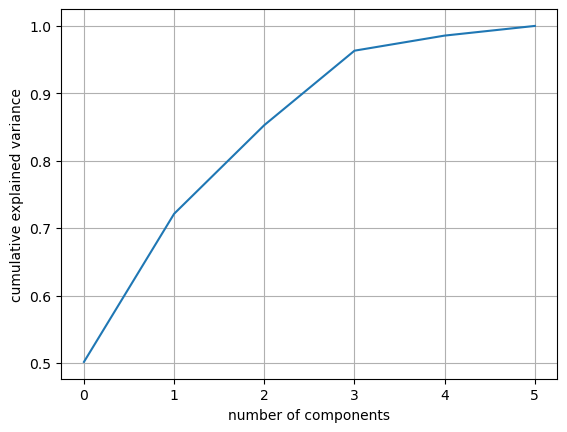

In [12]:
pca = PCA().fit(dts_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid()
plt.show()

<h1>Clustering</h1>

<hr>
    
Clustering algorithms are aimed at finding, based on the properties of the data, the optimal partitioning or discrete labeling of groups of points.

This technique is useful for finding natural patterns and trends in data and is often used during the exploratory data analysis phase to gain further understanding of the data. Additionally, clustering can be used to divide a dataset into distinct segments based on various variables.

The application of clustering algorithms is pretty simple, [scikit-learn has full supply](https://scikit-learn.org/stable/modules/clustering.html).

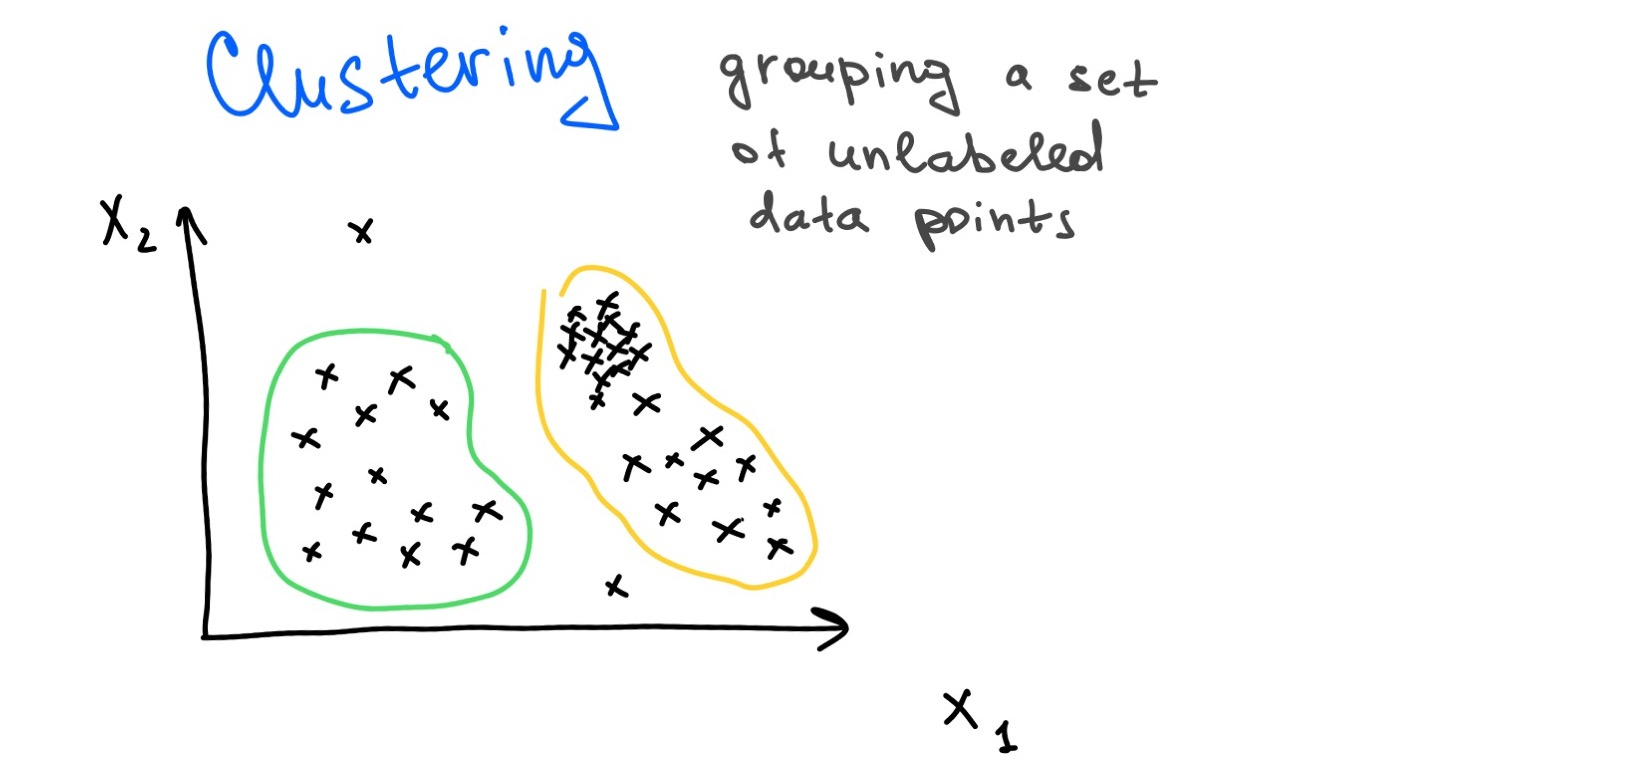

<h2>K-Means</h2>

Partitioning algorithms are based on specifying an initial number of groups, and iteratively reallocating objects among groups to convergence.

- "Cluster center" is the arithmetic mean of all points belonging to this cluster.

- Each point is closer to the center of its cluster than to the centers of other clusters.

In [28]:
# applying kmeans on the dataset with number of clusters=3
kmeans = KMeans(n_clusters=2)
# learning
kmeans.fit(crds_pca)
# prediction
y_kmeans = kmeans.predict(crds_pca)

# Final locations of the centroid
centroids = kmeans.cluster_centers_
 
print("The number of iterations required to converge:", kmeans.n_iter_)

The number of iterations required to converge: 9


In [29]:
centroids

array([[ 7.36259185, -0.48345302],
       [-0.26218889,  0.01721622]])

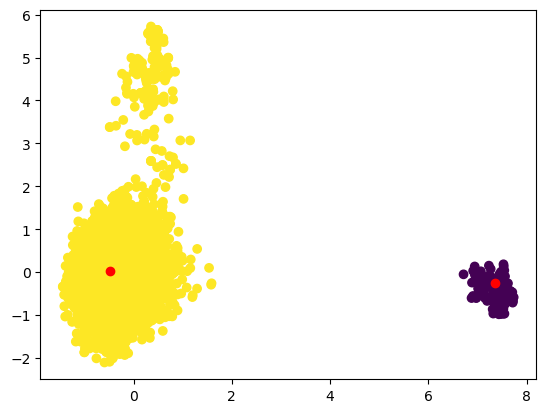

In [30]:
#visualize results
plt.scatter(crds_pca[:, 0], crds_pca[:, 1], c=y_kmeans)
plt.scatter(centroids[0, :], centroids[1, :], c='red', marker='o')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The number of iterations required to converge: 2


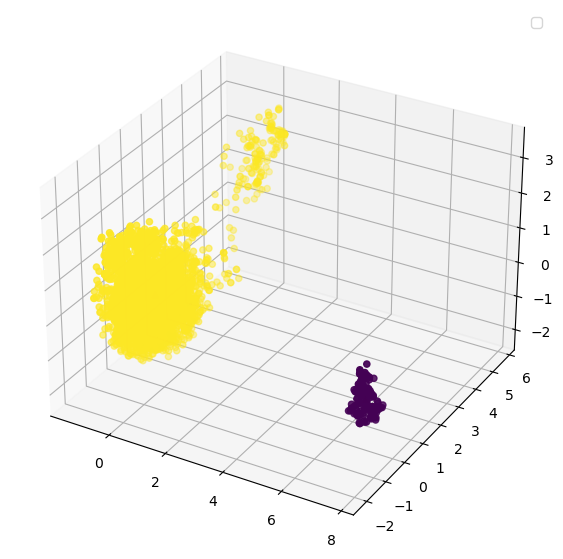

In [15]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(fps_pca_3d)

y_kmeans = kmeans.predict(fps_pca_3d)
centroids = kmeans.cluster_centers_
 
print("The number of iterations required to converge:", kmeans.n_iter_)

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(fps_pca_3d[:, 0], fps_pca_3d[:, 1], fps_pca_3d[:, 2], c=y_kmeans)
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='red', marker='^')
ax.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The number of iterations required to converge: 38


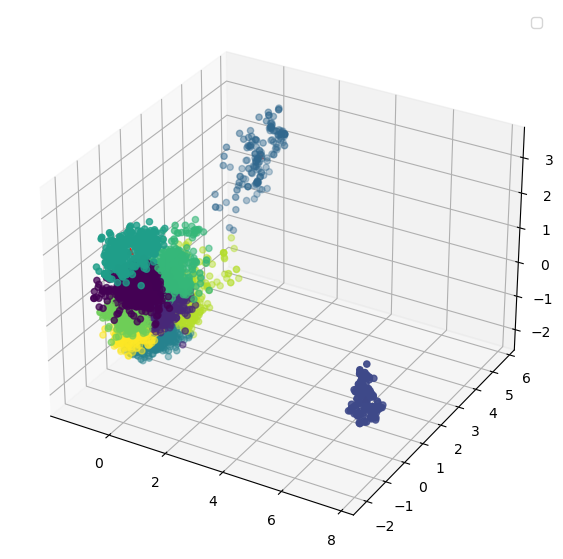

In [16]:
# Let's say there are 10 clusters..
kmeans = KMeans(n_clusters=10)
kmeans.fit(fps_pca_3d)

y_kmeans = kmeans.predict(fps_pca_3d)
centroids = kmeans.cluster_centers_
 
print("The number of iterations required to converge:", kmeans.n_iter_)

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(fps_pca_3d[:, 0], fps_pca_3d[:, 1], fps_pca_3d[:, 2], c=y_kmeans)
ax.scatter(centroids[0, :], centroids[1, :], centroids[2, :], c='red', marker='^')
ax.legend()
plt.show()

<h2>Hierarchical Clustering Algorithm</h2>

In [17]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward') 
labels = cluster.fit_predict(fps)

/var/folders/58/6gqg3qf555lfcdvk2vbvf5_r0000gn/T/ipykernel_44488/3731232832.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


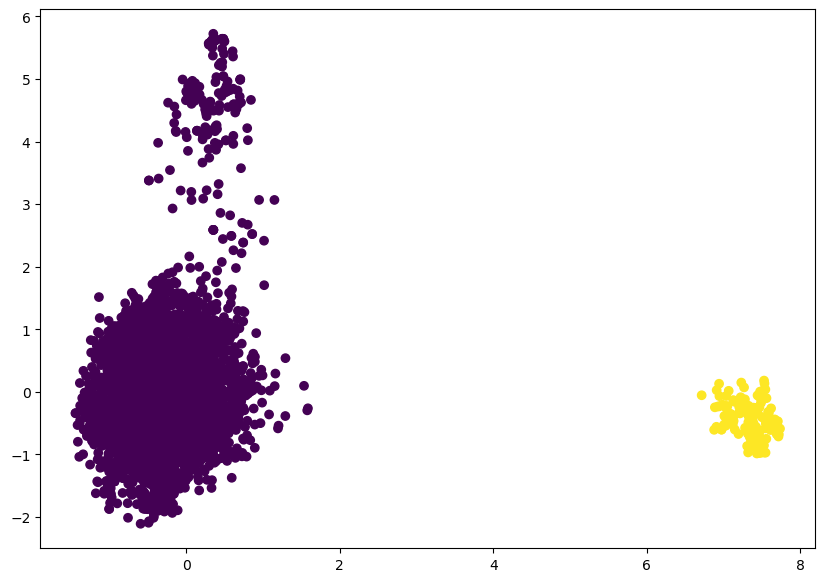

In [18]:
plt.figure(figsize=(10, 7)) 
plt.scatter(crds_pca[:, 0], crds_pca[:, 1], c=labels)
fig.show()

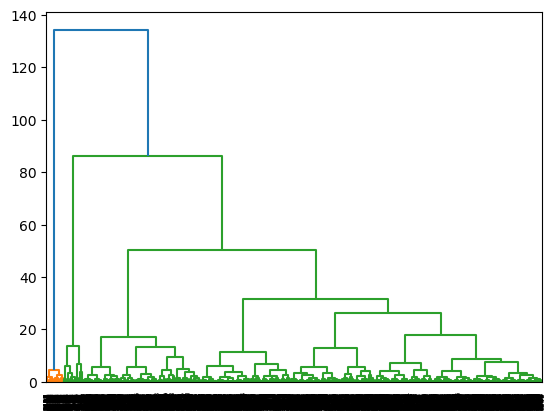

In [19]:
data = list(zip(crds_pca[:, 0], crds_pca[:, 1]))
linkage_data = linkage(data, method='ward', metric='euclidean')
dendrogram(linkage_data)
plt.show()

/var/folders/58/6gqg3qf555lfcdvk2vbvf5_r0000gn/T/ipykernel_44488/2952047289.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


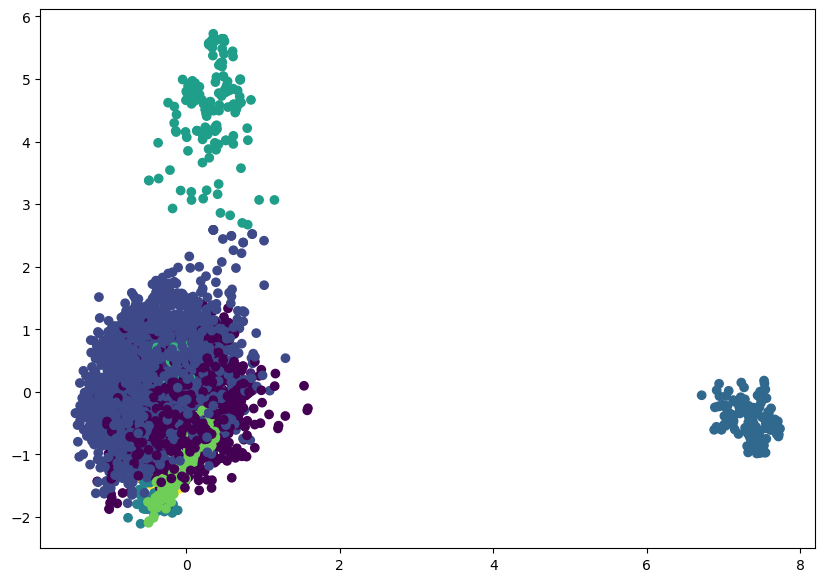

In [20]:
# Let's say there are 10 clusters..
cluster = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward') 
labels = cluster.fit_predict(fps)

plt.figure(figsize=(10, 7)) 
plt.scatter(crds_pca[:, 0], crds_pca[:, 1], c=labels)
fig.show()

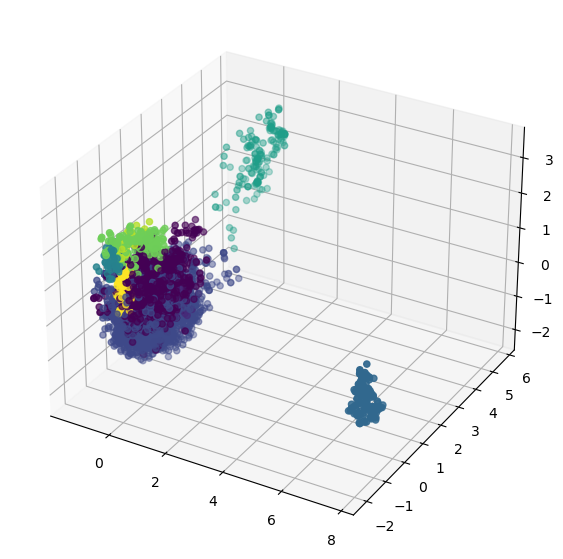

In [21]:
cluster = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward') 
labels = cluster.fit_predict(fps)

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(fps_pca_3d[:, 0], fps_pca_3d[:, 1], fps_pca_3d[:, 2], c=labels)
plt.show()